In [184]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brute
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [3]:
time_series = pd.read_csv('time_series.csv').astype('float32')
time_series.head()

,Year,Month,NumCases
0,1980.0,1.0,1825.0
1,1980.0,2.0,1730.0
2,1980.0,3.0,1743.0
3,1980.0,4.0,1760.0
4,1980.0,5.0,1863.0


In [11]:
train = time_series[:-60]
test = time_series[-60:]

X_train = train[train.columns[3:]].to_numpy()
Y_train = train['NumCases'].to_numpy()

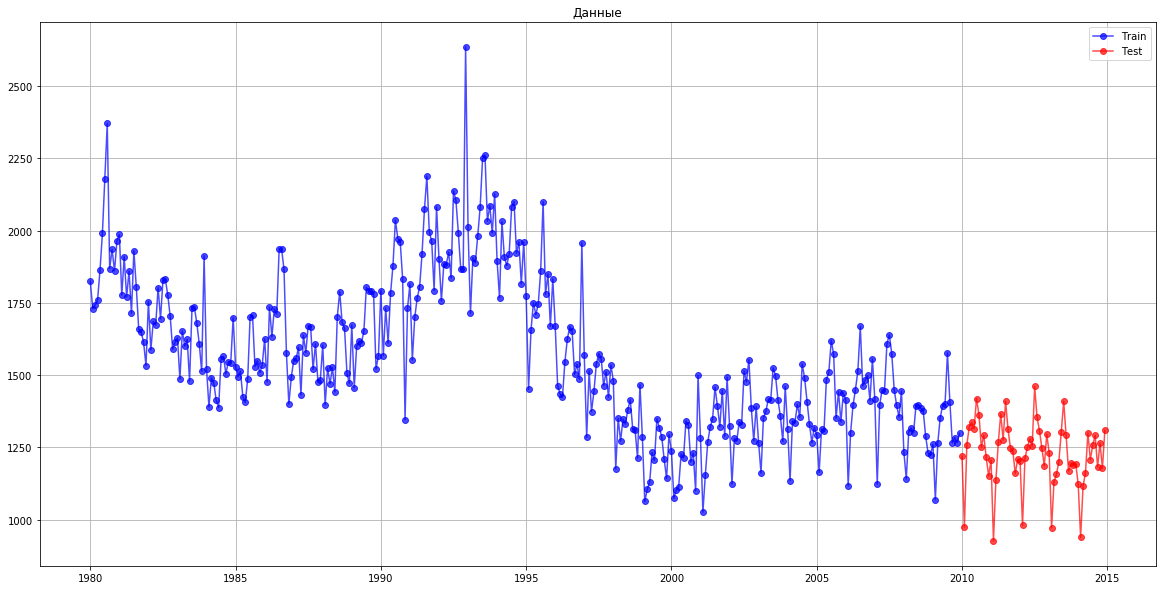

In [27]:
plt.figure(figsize=(20,10))
plt.plot(train['Date'], train['NumCases'], color='b', marker='o', alpha=0.7, label='Train')
plt.plot(test['Date'], test['NumCases'], color='r', marker='o', alpha=0.7, label='Test')
plt.title('Данные')
plt.grid()
plt.legend()
plt.show()


### Стационарность 

In [19]:
from statsmodels.tsa.stattools import adfuller
print("Критерий Дики-Фуллера: p=%f" % adfuller(train['NumCases'])[1])

Критерий Дики-Фуллера: p=0.346374


Критерий Дики-Фуллера: p=0.000010


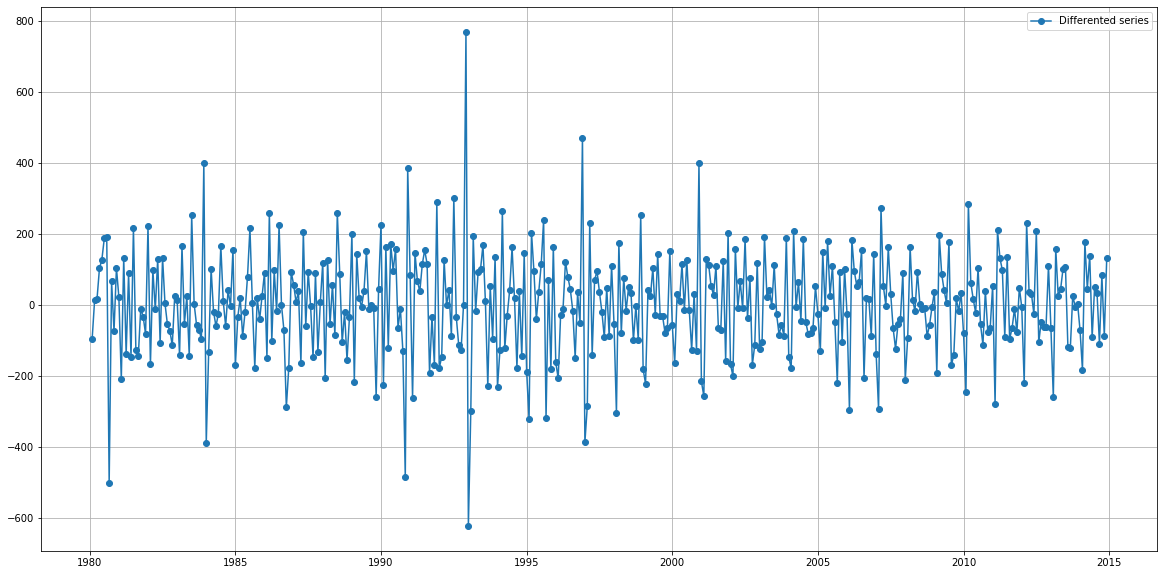

In [28]:
time_series['NumCasesDiff'] = time_series['NumCases'] - time_series['NumCases'].shift(1)
print("Критерий Дики-Фуллера: p=%f" % adfuller(time_series['NumCasesDiff'][1:])[1])
plt.figure(figsize=(20,10))
plt.plot(time_series['Date'], time_series['NumCasesDiff'], marker='o', label='Differented series')
plt.grid()
plt.legend()
plt.show()

In [35]:
train['NumCasesDiff'] = time_series['NumCasesDiff'][:-60]
test['NumCasesDiff'] = time_series['NumCasesDiff'][-60:]

/Users/bobrg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/bobrg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Автокорреляция и частичная автокорреляция

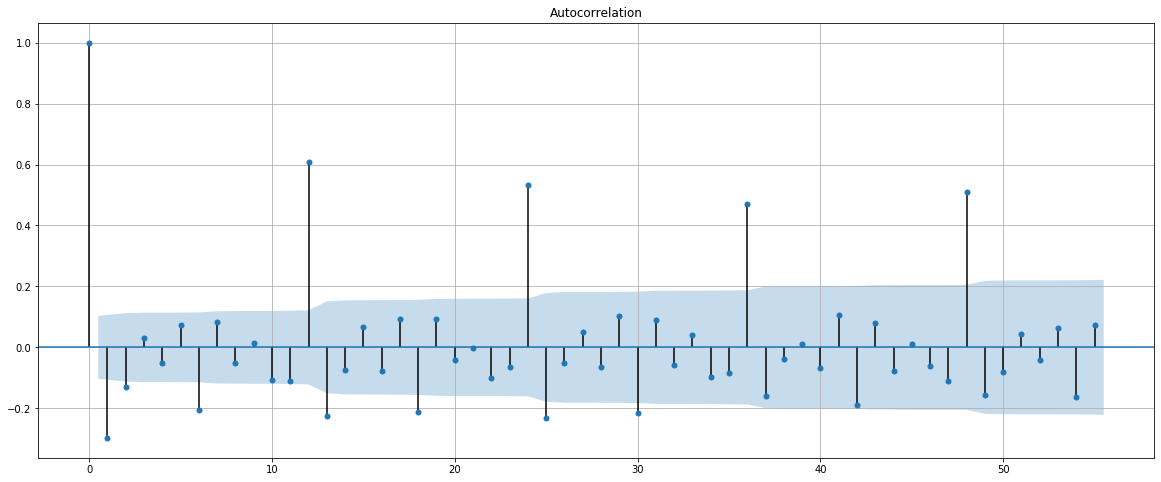

In [110]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_acf(train['NumCasesDiff'].values[1:], lags=55, ax=ax)
plt.grid(True)
plt.show()

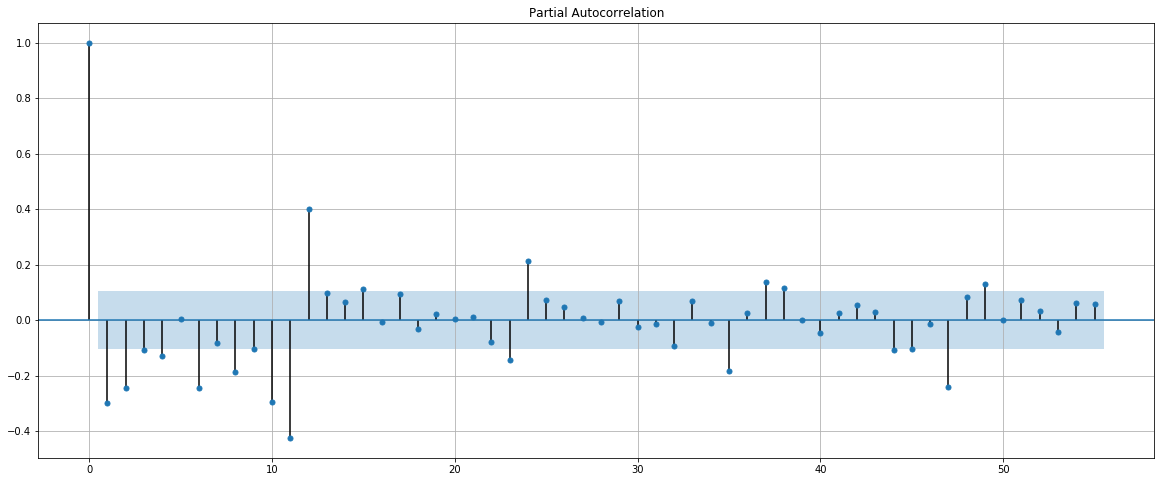

In [39]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_pacf(train['NumCasesDiff'].values[1:], lags=55, ax=ax)
plt.grid(True)
plt.show()

### ARIMA


In [111]:
exog = None
residuals = dict()
for pi, qi in [[1, 0], [1, 1], [11, 0], 
               [11, 1], [12, 0], [12, 1], 
               [24, 0], [24, 12]]:
    
    fit = ARIMA(train['NumCasesDiff'][1:], (pi, 0, qi), exog).fit(disp=0)
    print(f'p={pi}, q={qi} -----> aic={fit.aic}')
    residuals[f'{pi}_{qi}'] = fit.resid

/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


p=1, q=0 -----> aic=4597.766321180147
p=1, q=1 -----> aic=4547.123491437237
p=11, q=0 -----> aic=4448.0955370956535
p=11, q=1 -----> aic=4415.479113357555
p=12, q=0 -----> aic=4387.165884748269
p=12, q=1 -----> aic=4381.4370110687705
p=24, q=0 -----> aic=4375.570556147507


/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


p=24, q=12 -----> aic=4338.39704004432


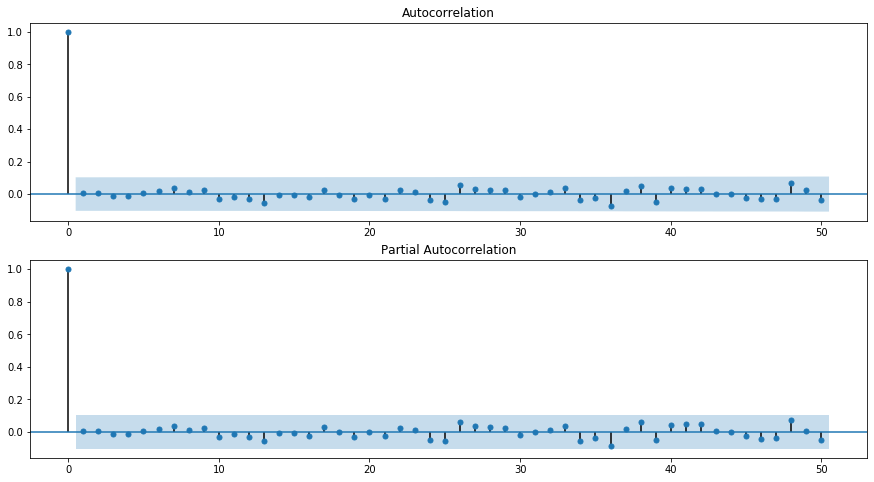

In [212]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(residuals['24_12'], lags=50, ax=ax[0])
fig = plot_pacf(residuals['24_12'], lags=50, ax=ax[1])
plt.show()

Text(0.5, 1.0, 'Residuals distribution ARIMA')

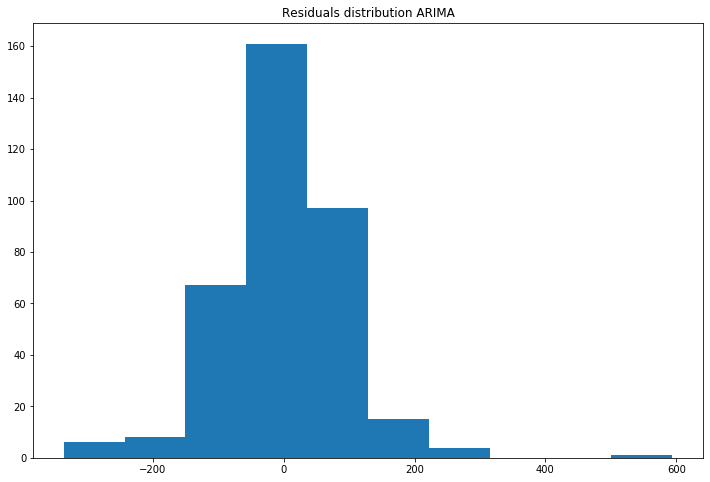

In [209]:
fig = plt.figure(figsize=(12,8))
plt.hist(residuals['24_12']);
plt.title('Residuals distribution ARIMA')

**Остатки имеют почти нулевую корреляцию и близки к нулю ==> предсказание хорошее**

In [199]:
prediction_ARIMA_diff = fit.forecast(steps=60)[0]
# transform from diff 
prediction_ARIMA = np.concatenate((train['NumCasesDiff'][1:].values, prediction_ARIMA_diff)).cumsum() + train['NumCases'][0]

print(F'RMSE ARIMA: {np.sqrt(mean_squared_error(prediction_ARIMA[-60:], test.NumCases))}')

RMSE ARIMA: 64.92510206503698


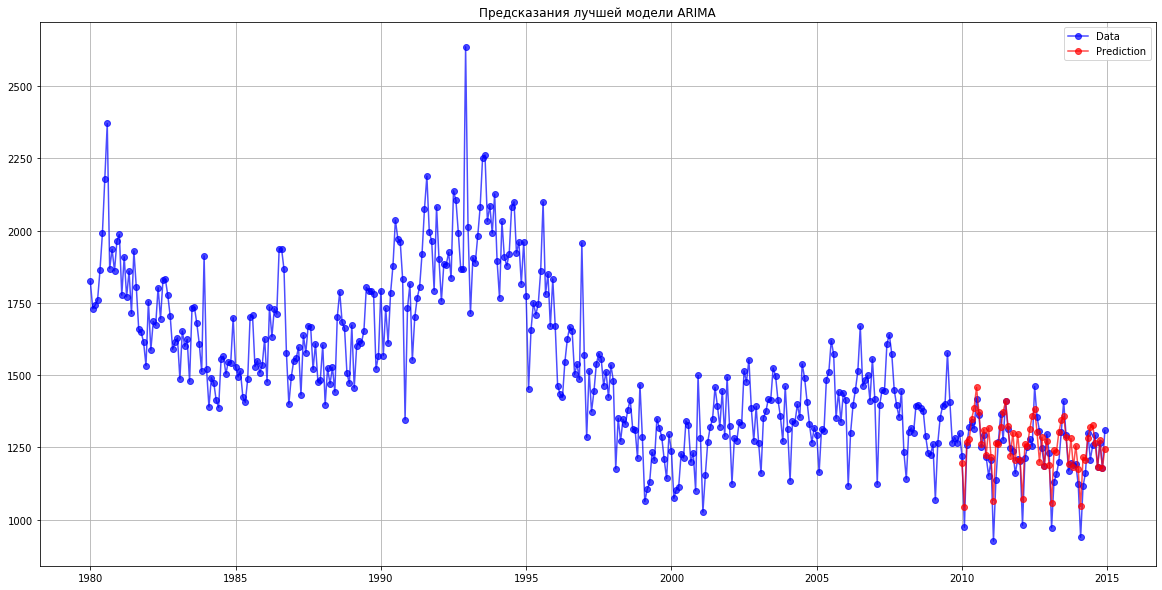

In [196]:
plt.figure(figsize=(20,10))
plt.plot(time_series['Date'], time_series['NumCases'], color='b', marker='o', alpha=0.7, label='Data')
plt.plot(test['Date'], prediction_ARIMA[-60:], color='r', marker='o', alpha=0.7, label='Prediction')
plt.title('Предсказания лучшей модели ARIMA')
plt.grid()
plt.legend()
plt.show()


### ARIMAX

In [178]:
#month one hot encoding
month_dummies = pd.get_dummies(time_series['Month'])
month_dummies.columns = ['month-'+ str(m) for m in range(1,13)]
exog_train = month_dummies[:-60]
exog_test = month_dummies[-60:]

In [201]:
exog = None
residuals_arimax = dict()
for pi, qi in [[1, 0], [1, 1], [11, 0], 
               [11, 1], [12, 0], [12, 1], 
               [24, 0], [24, 12], [49, 48]]:
    
    arimax = SARIMAX(train['NumCasesDiff'].astype(float), order=(pi,0,qi), seasonal_order=(0,0,0,0),exog = exog_train).fit()
    arimax_pred = arimax.forecast(steps=60, exog=exog_test)
    arimax_pred = np.concatenate((train['NumCasesDiff'][1:].values, arimax_pred)).cumsum() + train['NumCases'][0]
    print(f'p={pi}, q={qi} -----> aic={arimax.aic}, RMSE={np.sqrt(mean_squared_error(arimax_pred[-60:], test.NumCases))}')
    residuals_arimax[f'{pi}_{qi}'] = arimax.resid

p=1, q=0 -----> aic=4351.51293471504, RMSE=69.41140814584658
p=1, q=1 -----> aic=4308.781729904977, RMSE=64.68329195094437
p=11, q=0 -----> aic=4309.154366124422, RMSE=63.25005053439137
p=11, q=1 -----> aic=4305.791711833947, RMSE=62.65085243029321
p=12, q=0 -----> aic=4299.391187320916, RMSE=62.15317388891843
p=12, q=1 -----> aic=4301.387602070285, RMSE=62.15164255724005
p=24, q=0 -----> aic=4306.439457659086, RMSE=65.23867908790915


/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


p=24, q=12 -----> aic=4317.705988411884, RMSE=66.75863674261365


/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


p=49, q=48 -----> aic=4387.332523113073, RMSE=73.4915482053515


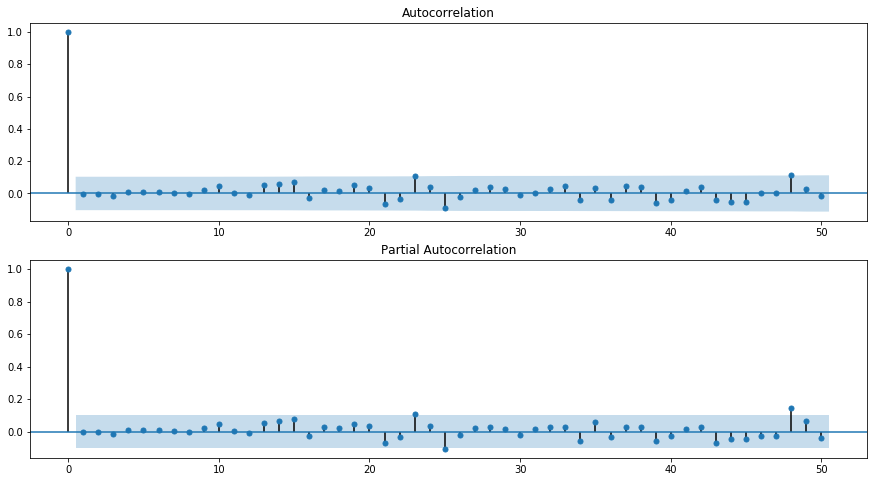

In [190]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(residuals_arimax['12_0'][1:], lags=50, ax=ax[0])
fig = plot_pacf(residuals_arimax['12_0'][1:], lags=50, ax=ax[1])
plt.show()

Text(0.5, 1.0, 'Residuals distribution')

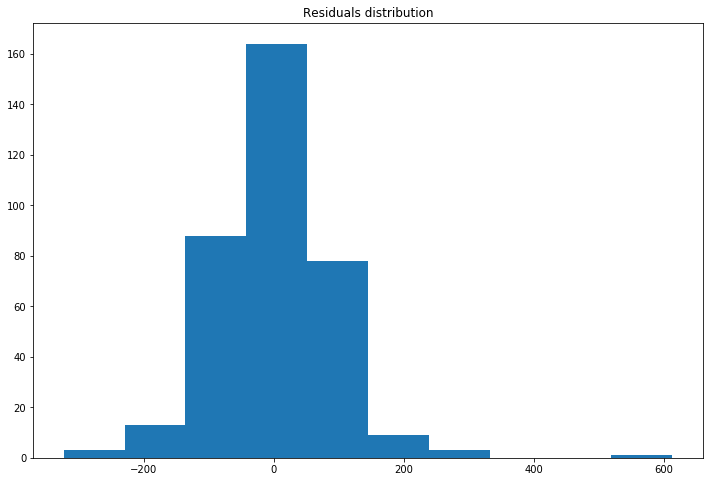

In [207]:
fig = plt.figure(figsize=(12,8))
plt.hist(residuals_arimax['12_0'][1:]);
plt.title('Residuals distribution')

**Остатки имеют почти нулевую корреляцию и близки к нулю ==> предсказание хорошее**

In [198]:
arimax = SARIMAX(train['NumCasesDiff'].astype(float), order=(12,0,0), seasonal_order=(0,0,0,0),exog = exog_train).fit()
prediction_SARIMAX_diff = arimax.forecast(steps=60, exog=exog_test)
# transform from diff 
prediction_SARIMAX = np.concatenate((train['NumCasesDiff'][1:].values, prediction_SARIMAX_diff)).cumsum() + train['NumCases'][0]
print(F'RMSE ARIMAX: {np.sqrt(mean_squared_error(prediction_SARIMAX[-60:], test.NumCases))}')


RMSE ARIMAX: 62.15317388891843


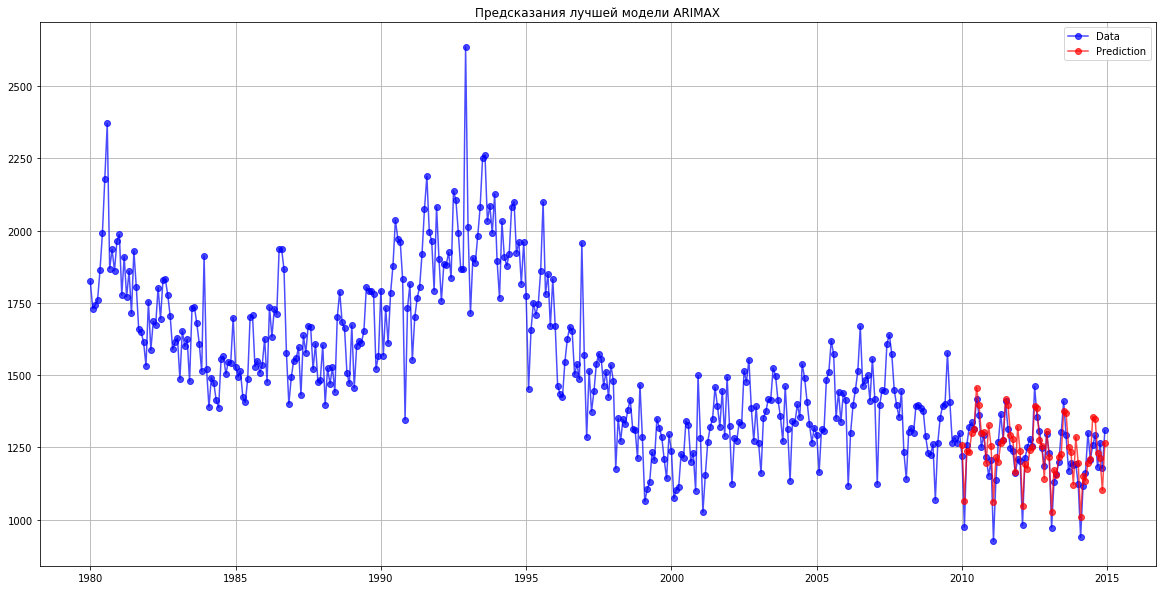

In [200]:
plt.figure(figsize=(20,10))
plt.plot(time_series['Date'], time_series['NumCases'], color='b', marker='o', alpha=0.7, label='Data')
plt.plot(test['Date'], prediction_SARIMAX[-60:], color='r', marker='o', alpha=0.7, label='Prediction')
plt.title('Предсказания лучшей модели ARIMAX')
plt.grid()
plt.legend()
plt.show()


### Быстродействие

### ARIMA

In [174]:
n = 10
fit_times = []
for i in range(n):
    t1 = time.time()
    arima = ARIMA(train['NumCasesDiff'][1:], (24, 0, 12), exog).fit(disp=0)
    t2 = time.time()
    fit_times.append(t2 - t1)
print(f'SARIMA fitting time {np.mean(fit_times)}s')

/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params 

SARIMA fitting time 2068.3072345018386s


/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/bobrg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [175]:
n = 10
pred_times = []
for i in range(n):
    t1 = time.time()
    predictions_data = arima.forecast(steps=60)[0]
    t2 = time.time()
    pred_times.append(t2 - t1)
print(f'SARIMA prediction time {np.mean(pred_times)}s')

SARIMA prediction time 0.016436290740966798s


### ARIMAX

In [193]:
n = 10
fit_times = []
for i in range(n):
    t1 = time.time()
    arimax = SARIMAX(train['NumCasesDiff'].astype(float), order=(12,0,0), seasonal_order=(0,0,0,0),exog = exog_train).fit()
    t2 = time.time()
    fit_times.append(t2 - t1)
print(f'SARIMA fitting time {np.mean(fit_times)}s')

SARIMA fitting time 1.3739166975021362s


In [194]:
n = 10
pred_times = []
for i in range(n):
    t1 = time.time()
    predictions_data = arimax.forecast(steps=60, exog=exog_test)
    t2 = time.time()
    pred_times.append(t2 - t1)
print(f'SARIMA prediction time {np.mean(pred_times)}s')

SARIMA prediction time 0.0076771736145019535s
